In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install --upgrade sympy

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple

# Define map elements
EMPTY = 0
WALL = 1
LAVA = 2
TREASURE = 3
EXIT = 4
START = 5
ENEMY = 6

# Define Colors for Visualization
COLOR_MAP = {
    EMPTY: "white",
    WALL: "brown",
    LAVA: "red",
    TREASURE: "yellow",
    EXIT: "green",
    START: "blue",
    ENEMY: "purple",
}

# Experience replay buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

In [2]:
class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
    
        grid_batch = torch.cat([e.state[0] for e in experiences])           # [B, 8, 20, 20]
        diff_batch = torch.cat([e.state[1] for e in experiences])           # [B, 1]
        actions = torch.tensor([e.action for e in experiences])
        rewards = torch.tensor([e.reward for e in experiences], dtype=torch.float)
    
        next_grid_batch = torch.cat([e.next_state[0] for e in experiences])  # [B, 8, 20, 20]
        next_diff_batch = torch.cat([e.next_state[1] for e in experiences])  # [B, 1]
        dones = torch.tensor([e.done for e in experiences], dtype=torch.float)
    
        return grid_batch, diff_batch, actions, rewards, next_grid_batch, next_diff_batch, dones


    def __len__(self):
        return len(self.buffer)

In [3]:
class CNN_DQNModel(nn.Module):
    def __init__(self, output_dim):
        super(CNN_DQNModel, self).__init__()

        # CNN layers to extract spatial features
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples to 10x10

        # Fully connected layers after flattening
        self.fc1 = nn.Linear(64 * 10 * 10 + 1, 256)  # +1 for difficulty input
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, grid_input, difficulty_input):
        x = F.relu(self.conv1(grid_input))         # [B, 32, 20, 20]
        x = F.relu(self.conv2(x))                  # [B, 64, 20, 20]
        x = self.pool(x)                           # [B, 64, 10, 10]
        x = x.view(x.size(0), -1)                  # Flatten [B, 6400]

        x = torch.cat((x, difficulty_input), dim=1)  # Concatenate difficulty: [B, 6401]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)                         # [B, 9]

In [4]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

class DungeonAgent:
    def __init__(self, action_size, buffer_size=10000, batch_size=64, gamma=0.99,
                 lr=1e-4, tau=1e-3, epsilon_start=1.0, epsilon_end=0.0000001, epsilon_decay=0.999999):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.training_losses = []

        # Q-Network (CNN)
        self.qnetwork = CNN_DQNModel(output_dim=action_size)
        self.target_network = CNN_DQNModel(output_dim=action_size)
        self.optimizer = torch.optim.Adam(self.qnetwork.parameters(), lr=lr)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qnetwork.to(self.device)
        self.target_network.to(self.device)

    def act(self, grid_tensor, difficulty_tensor, eps_override=None):
        """Choose action based on epsilon-greedy strategy."""
        eps = self.epsilon if eps_override is None else eps_override
        if random.random() < eps:
            return random.choice(range(self.action_size))

        self.qnetwork.eval()
        with torch.no_grad():
            grid_tensor = grid_tensor.to(self.device)
            difficulty_tensor = difficulty_tensor.to(self.device)
            q_values = self.qnetwork(grid_tensor, difficulty_tensor)
        self.qnetwork.train()

        return torch.argmax(q_values).item()

    def step(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) >= self.batch_size:
            self.learn()

    def learn(self):
        batch = random.sample(self.memory, self.batch_size)

        # Unpack and prepare batches
        grid_batch = torch.cat([s[0] for s, _, _, _, _ in batch]).to(self.device)            # [B, 8, 20, 20]
        diff_batch = torch.cat([s[1] for s, _, _, _, _ in batch]).to(self.device)            # [B, 1]
        actions = torch.tensor([a for _, a, _, _, _ in batch], dtype=torch.long).to(self.device)
        rewards = torch.tensor([r for _, _, r, _, _ in batch], dtype=torch.float32).to(self.device)
        next_grid_batch = torch.cat([ns[0] for _, _, _, ns, _ in batch]).to(self.device)
        next_diff_batch = torch.cat([ns[1] for _, _, _, ns, _ in batch]).to(self.device)
        dones = torch.tensor([d for _, _, _, _, d in batch], dtype=torch.float32).to(self.device)

        # Get current Q values
        q_values = self.qnetwork(grid_batch, diff_batch)                    # [B, 9]
        q_expected = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)   # [B]

        # Get next Q values from target network
        with torch.no_grad():
            q_next = self.target_network(next_grid_batch, next_diff_batch) # [B, 9]
            q_target = rewards + (1 - dones) * self.gamma * q_next.max(1)[0]

        # Loss and backpropagation
        loss = F.mse_loss(q_expected, q_target)
        self.training_losses.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target network
        self.soft_update()

        # Epsilon decay
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def soft_update(self):
        for target_param, local_param in zip(self.target_network.parameters(), self.qnetwork.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

In [5]:
class DungeonEnvironment:
    def __init__(self, difficulty=5, board_size=20):
        self.board_size = board_size
        self.difficulty = difficulty
        self.max_enemies = 4

        self.element_types = [EMPTY, WALL, LAVA, TREASURE, EXIT, START, ENEMY]
        self.placement_types = [LAVA, TREASURE, ENEMY, WALL, EMPTY]

        self.grid = np.zeros((board_size, board_size), dtype=np.int8)
        self.cursor = None
        self.start_pos = None
        self.exit_pos = None
        self.steps = 0
        self.max_steps = 600

        self._setup_playable_area()

    def _setup_playable_area(self):
        """Define and fill the playable area based on difficulty."""
        # Scale playable area size with difficulty
        min_playable = 5
        max_playable = 18
        playable_size = min_playable + (self.difficulty - 1) * (max_playable - min_playable) // 9
        self.playable_width = self.playable_height = playable_size

        # Center the playable area
        self.playable_start_x = (self.board_size - self.playable_width) // 2
        self.playable_start_y = (self.board_size - self.playable_height) // 2
        self.playable_end_x = self.playable_start_x + self.playable_width - 1
        self.playable_end_y = self.playable_start_y + self.playable_height - 1

        self.object_counts = {k: 0 for k in self.placement_types}

    def reset(self):
        self.grid = np.zeros((self.board_size, self.board_size), dtype=int)
        self.steps = 0
        self._setup_playable_area()

        # Fill outer border with walls
        for y in range(self.board_size):
            for x in range(self.board_size):
                if (
                    x < self.playable_start_x or x > self.playable_end_x or
                    y < self.playable_start_y or y > self.playable_end_y
                ):
                    self.grid[y][x] = WALL

        #  Generate maze before placing START/EXIT
        self._generate_maze_layout()

        #  Place START
        self.start_pos = self._find_random_empty_cell()
        self.grid[self.start_pos[1]][self.start_pos[0]] = START

        # Place EXIT far away
        # Check find random empty cell
        min_dist = (self.playable_width + self.playable_height) * 0.75
        self.exit_pos = self._find_random_empty_cell(exclude=[self.start_pos], avoid_near=self.start_pos, min_distance=min_dist)
        self.grid[self.exit_pos[1]][self.exit_pos[0]] = EXIT

        #self._carve_simple_path(self.start_pos, self.exit_pos)

        # Check lava and wall free path
        safe_path = self._calculate_path_complexity(return_path=True)
        if not safe_path:
            return self.reset()
        self.safe_path = set(safe_path)

        self.cursor = list(self.start_pos)
        self.object_counts = {k: 0 for k in self.placement_types}
        self.visited = {tuple(self.cursor)}

        # Determine playable interior area
        playable_area = (self.playable_width - 2) * (self.playable_height - 2)

        # --- Suggested object limits based on size + difficulty ---
        self.suggested_treasure = max(1, int(playable_area * 0.04) - self.difficulty)
        self.suggested_lava = int(playable_area * (0.01 + 0.01 * self.difficulty))

        #  New logic for treasure limit
        max_treasure = max(1, int(0.25 * (playable_area ** 0.5)) - (self.difficulty // 2))
        max_treasure = min(max_treasure, 10)

        #  Lava and wall density updates
        lava_density = 0.01 + 0.005 * self.difficulty
        wall_density = 0.2 + 0.02 * self.difficulty

        max_lava = int(playable_area * lava_density)

        #  Enemy tier rules
        if self.difficulty <= 4:
            self.allowed_enemy_limit = 1
        elif self.difficulty <= 7:
            self.allowed_enemy_limit = random.randint(2, 3)
        else:
            self.allowed_enemy_limit = 5

        #  Place all elements after maze and START/EXIT
        self._place_random_objects(TREASURE, max_treasure)
        self._place_random_objects(LAVA, max_lava)
        self._place_random_objects(ENEMY, self.allowed_enemy_limit)

        return self._get_state()

    def _find_random_empty_cell(self, exclude=[], avoid_near=None, min_distance=0):
        """Find an empty cell that avoids proximity and overlaps."""
        candidates = [
            (x, y)
            for y in range(self.playable_start_y + 1, self.playable_end_y)
            for x in range(self.playable_start_x + 1, self.playable_end_x)
            if self.grid[y][x] == EMPTY and (x, y) not in exclude
        ]

        if avoid_near and min_distance > 0:
            candidates = [
                (x, y)
                for (x, y) in candidates
                if abs(x - avoid_near[0]) + abs(y - avoid_near[1]) >= min_distance
            ]

        return random.choice(candidates) if candidates else (self.playable_start_x + 1, self.playable_start_y + 1)

    def _place_random_objects(self, tile, count):
        placed = 0
        attempts = 0
        max_attempts = count * 30
        objects = random.randint(0, count)
        existing_positions = [
            (x, y)
            for y in range(self.playable_start_y + 1, self.playable_end_y)
            for x in range(self.playable_start_x + 1, self.playable_end_x)
            if self.grid[y][x] == tile
        ]

        # Generate a noise map for more natural placement
        noise = np.random.rand(self.board_size, self.board_size)

        while placed < objects and attempts < max_attempts:
            x = random.randint(self.playable_start_x + 1, self.playable_end_x - 1)
            y = random.randint(self.playable_start_y + 1, self.playable_end_y - 1)

            if (x, y) in [self.start_pos, self.exit_pos]:
                attempts += 1
                continue

            if self.grid[y][x] != EMPTY:
                attempts += 1
                continue

            if tile == TREASURE:
                # Keep treasures away from START
                if abs(x - self.start_pos[0]) + abs(y - self.start_pos[1]) < 5:
                    attempts += 1
                    continue

                # Avoid placing next to another treasure
                neighbors = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx != 0 or dy != 0)]
                near_treasure = any(
                    0 <= nx < self.board_size and 0 <= ny < self.board_size and self.grid[ny][nx] == TREASURE
                    for nx, ny in neighbors
                )
                if near_treasure:
                    attempts += 1
                    continue

                # Soft-distribution using noise map
                if noise[y][x] < 0.3:  # require higher randomness for spacing
                    attempts += 1
                    continue


            #  Don’t place lava on the safe path
            if tile == LAVA and (x, y) in getattr(self, 'safe_path', set()):
                attempts += 1
                continue

            # Use noise as a soft priority (prefer high noise values)
            if noise[y][x] < 0.5:
                attempts += 1
                continue

            self.grid[y][x] = tile
            existing_positions.append((x, y))
            placed += 1
            if tile in self.object_counts:
                self.object_counts[tile] += 1

            attempts += 1

    def step(self, action):
        self.steps += 1
        reward = 0
        done = False

        if action < 4:
            # Movement: up, down, left, right
            dx, dy = [(0, -1), (0, 1), (-1, 0), (1, 0)][action]
            new_x = min(max(self.cursor[0] + dx, self.playable_start_x + 1), self.playable_end_x - 1)
            new_y = min(max(self.cursor[1] + dy, self.playable_start_y + 1), self.playable_end_y - 1)
            self.cursor = [new_x, new_y]
            reward -= 0.1  # discourage wandering
        else:
            prev_path_exists = self._calculate_path_complexity() > 0
            tile = self.placement_types[action - 4]
            cx, cy = self.cursor
            current_tile = self.grid[cy][cx]

            # DO NOT overwrite START or EXIT
            if (cx, cy) in [self.start_pos, self.exit_pos]:
                reward -= 15  # Heavy penalty
            else:
                # Adjust old object count
                if current_tile in self.object_counts:
                    self.object_counts[current_tile] = max(0, self.object_counts[current_tile] - 1)

                self.grid[cy][cx] = tile
                if tile in self.object_counts:
                    self.object_counts[tile] += 1

                # WALL
                if tile == WALL:
                    reward += 2

                # TREASURE
                elif tile == TREASURE:
                    if self.object_counts[TREASURE] > self.suggested_treasure:
                        reward -= 5
                    else:
                        dist_to_start = abs(cx - self.start_pos[0]) + abs(cy - self.start_pos[1])
                        reward += 3 if dist_to_start >= 4 else -3

                        nearby = sum(
                            1 for dx in range(-2, 3) for dy in range(-2, 3)
                            if 0 <= cx+dx < self.board_size and 0 <= cy+dy < self.board_size and self.grid[cy+dy][cx+dx] == TREASURE
                        )
                        if nearby > 2:
                            reward -= 2

                #  ENEMY
                elif tile == ENEMY:
                    if self.object_counts[ENEMY] > self.allowed_enemy_limit:
                        reward -= 10 
                    else:
                        reward += 4

                #  LAVA
                elif tile == LAVA:
                    if self.object_counts[LAVA] > self.suggested_lava:
                        reward -= 4
                    else:
                        reward += 2

                #  EMPTY
                elif tile == EMPTY:
                    reward -= 1  

                # After placement, check if path is still valid
                new_path_exists = self._calculate_path_complexity() > 0
                if new_path_exists:
                    reward += 10
                if prev_path_exists and not new_path_exists:
                    reward -= 50
                elif not prev_path_exists and new_path_exists:
                    reward += 50

        # End of episode: give complexity bonus if valid path
        if self.steps >= self.max_steps:
            done = True    
            #  Reward complexity only if it's aligned with difficulty
            if complexity > 0:
                # Expect harder levels to be more complex
                target_complexity = min(1.0, 0.3 + 0.07 * self.difficulty)
                reward += (1 - abs(complexity - target_complexity)) * 20 + complexity *30
            else:
                reward -= 100
        
        return self._get_state(), reward, done


        return self._get_state(), reward, done

    def _get_state(self):
        """
        Returns:
            - grid_tensor: [1, 8, 20, 20] — for CNN input
            - difficulty_tensor: [1, 1] — appended in FC layer
        """
        one_hot_grid = np.zeros((7, self.board_size, self.board_size), dtype=np.float32)
        for i in range(7):
            one_hot_grid[i] = (self.grid == i).astype(np.float32)
    
        # Cursor as binary channel
        cursor_channel = np.zeros((1, self.board_size, self.board_size), dtype=np.float32)
        cursor_x, cursor_y = self.cursor
        cursor_channel[0, cursor_y, cursor_x] = 1.0
    
        # Stack to form 8-channel input
        combined = np.concatenate([one_hot_grid, cursor_channel], axis=0)  # [8, 20, 20]
    
        grid_tensor = torch.tensor(combined, dtype=torch.float32).unsqueeze(0)  # [1, 8, 20, 20]
        difficulty_tensor = torch.tensor([[self.difficulty / 10.0]], dtype=torch.float32)  # [1, 1]
    
        return grid_tensor, difficulty_tensor

    def _calculate_path_complexity(self, return_path=False):
        allowed_tiles = {EMPTY, START, EXIT, ENEMY, TREASURE}
        visited = np.zeros((self.board_size, self.board_size), dtype=bool)
        queue = [(self.start_pos, 0, [self.start_pos])]
        visited[self.start_pos[1]][self.start_pos[0]] = True

        while queue:
            (x, y), dist, path = queue.pop(0)
            if (x, y) == self.exit_pos:
                return path if return_path else dist / (self.playable_width + self.playable_height)

            for dx, dy in [(0, -1), (1, 0), (0, 1), (-1, 0)]:
                nx, ny = x + dx, y + dy
                if (self.playable_start_x <= nx <= self.playable_end_x and
                    self.playable_start_y <= ny <= self.playable_end_y and
                    not visited[ny, nx] and self.grid[ny][nx] in allowed_tiles):
                    visited[ny, nx] = True
                    queue.append(((nx, ny), dist + 1, path + [(nx, ny)]))

        return [] if return_path else 0

    def _generate_maze_layout(self):
        """Prim's Algorithm to generate maze walls inside playable area"""
        maze = np.ones((self.playable_height, self.playable_width), dtype=np.int8)

        def in_bounds(x, y):
            return 0 <= x < self.playable_width and 0 <= y < self.playable_height

        def neighbors(x, y):
            dirs = [(-2, 0), (2, 0), (0, -2), (0, 2)]
            result = []
            for dx, dy in dirs:
                nx, ny = x + dx, y + dy
                if in_bounds(nx, ny):
                    result.append((nx, ny))
            return result

        start_x = random.randrange(1, self.playable_width, 2)
        start_y = random.randrange(1, self.playable_height, 2)
        maze[start_y][start_x] = 0
        frontier = [(start_x, start_y)]

        while frontier:
            x, y = frontier.pop(random.randint(0, len(frontier) - 1))
            for nx, ny in neighbors(x, y):
                if maze[ny][nx] == 1:
                    between_x = (x + nx) // 2
                    between_y = (y + ny) // 2
                    maze[ny][nx] = 0
                    maze[between_y][between_x] = 0
                    frontier.append((nx, ny))

        # Convert maze to global coordinates
        for y in range(self.playable_height):
            for x in range(self.playable_width):
                global_x = self.playable_start_x + x
                global_y = self.playable_start_y + y
                if maze[y][x] == 1:
                    self.grid[global_y][global_x] = WALL

In [6]:
import time
import matplotlib.pyplot as plt

def one_hot_encode_grid_with_cursor(grid, cursor, num_tile_types=7):
    """
    Converts a 2D grid and cursor position into an 8-channel tensor [8, 20, 20]
    """
    grid_tensor = torch.tensor(grid, dtype=torch.long)
    one_hot = F.one_hot(grid_tensor, num_classes=num_tile_types)  # [20, 20, 7]
    one_hot = one_hot.permute(2, 0, 1).float()  # [7, 20, 20]

    # Add 8th channel for cursor
    cursor_channel = torch.zeros((1, 20, 20), dtype=torch.float32)
    cursor_x, cursor_y = cursor
    cursor_channel[0, cursor_y, cursor_x] = 1.0

    full_tensor = torch.cat([one_hot, cursor_channel], dim=0)  # [8, 20, 20]
    return full_tensor

def encode_difficulty(difficulty):
    """
    Converts a scalar difficulty (1–10) into a normalized tensor [B, 1]
    """
    return torch.tensor([[difficulty / 10.0]], dtype=torch.float32)  # shape [1, 1]

def train_dungeon_generator(num_episodes=1000, model_path="dungeon_rl_model.pth"):
    """Train a single RL model to generate levels for all difficulties with diagnostics (CNN version)."""
    envs = {d: DungeonEnvironment(d) for d in range(1, 11)}
    tile_types = len(envs[1].element_types)  # should be 7
    action_size = 9

    agent = DungeonAgent(action_size=action_size)  # Updated: remove state_size since CNN doesn't need it

    episode_rewards = []
    t0 = time.time()

    for episode in range(num_episodes):
        difficulty = min(1 + episode // 200, 10)
        env = envs[difficulty]
        env.reset()

        # Prepare state (CNN-compatible)
        grid_tensor = one_hot_encode_grid_with_cursor(env.grid, env.cursor).unsqueeze(0)
        difficulty_tensor = encode_difficulty(env.difficulty)               # [1, 1]
        state = (grid_tensor, difficulty_tensor)

        done = False
        total_reward = 0
        losses_before = len(agent.training_losses)

        while not done:
            # Forward pass: act
            action = agent.act(*state)  # Unpack grid and difficulty

            # Environment transition
            _, reward, done = env.step(action)

            # Prepare next state
            next_grid_tensor = onext_grid_tensor = one_hot_encode_grid_with_cursor(env.grid, env.cursor).unsqueeze(0)
            next_difficulty_tensor = encode_difficulty(env.difficulty)      # [1, 1]
            next_state = (next_grid_tensor, next_difficulty_tensor)

            # Learning step
            agent.step(state, action, reward, next_state, done)

            # Transition
            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)

        # Logging
        if episode % 50 == 0 and episode > 0:
            elapsed = time.time() - t0
            avg_reward = sum(episode_rewards[-50:]) / 50
            avg_loss = (sum(agent.training_losses[losses_before:]) /
                        max(1, len(agent.training_losses) - losses_before))
            print(f"Episode {episode} | Avg Reward: {avg_reward:.2f} | Avg Loss: {avg_loss:.4f} | "
                  f"Epsilon: {agent.epsilon:.3f} | Time: {elapsed:.2f}s")
            t0 = time.time()

    # Save model
    torch.save(agent.qnetwork.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

    # Plot diagnostics
    plot_training_diagnostics(episode_rewards, agent.training_losses)

    return agent, envs

def plot_training_diagnostics(rewards, losses):
    """Plot rewards and losses."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(rewards)
    ax1.set_title("Episode Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")

    ax2.plot(losses)
    ax2.set_title("Q-Network Losses")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

def generate_dungeon_with_model(agent, difficulty):
    env = DungeonEnvironment(difficulty)
    state = env.reset()  # returns just the grid
    done = False

    while not done:
        grid_tensor, difficulty_tensor = state  # since env.reset() returns (grid_tensor, difficulty_tensor)
        difficulty_tensor = torch.tensor([[difficulty / 10.0]], dtype=torch.float32)

        action = agent.act(grid_tensor, difficulty_tensor, eps_override=0.0)

        if random.random() < 0.2:
            action = random.randint(0, 8)

        state, _, done = env.step(action)

    return env.grid

def visualize_dungeon(grid):
    """Display dungeon grid using matplotlib."""
    fig, ax = plt.subplots(figsize=(6, 6))
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            rect = plt.Rectangle(
                (x, grid.shape[0] - y - 1), 1, 1,
                facecolor=COLOR_MAP[grid[y, x]],
                edgecolor='black'
            )
            ax.add_patch(rect)

    ax.set_xlim(0, grid.shape[1])
    ax.set_ylim(0, grid.shape[0])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title("Generated Dungeon")
    plt.show()

In [7]:
def load_trained_agent(model_path="/content/drive/MyDrive/FAI/dungeon_rl_model.pth"):
    """Load the trained model weights into a new agent."""
    grid_size = 20 * 20
    tile_types = len(COLOR_MAP)
    state_size = grid_size * tile_types + 2
    action_size = 9

    agent = DungeonAgent(state_size=state_size, action_size=action_size)
    agent.qnetwork.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    agent.qnetwork.eval()

    print(f"Model loaded from: {model_path}")
    return agent


Episode 50 | Avg Reward: -159.78 | Avg Loss: 105.8249 | Epsilon: 0.970 | Time: 410.09s
Episode 100 | Avg Reward: 251.06 | Avg Loss: 302.1433 | Epsilon: 0.941 | Time: 338.70s
Episode 150 | Avg Reward: 587.85 | Avg Loss: 685.6654 | Epsilon: 0.913 | Time: 336.95s
Episode 200 | Avg Reward: 549.74 | Avg Loss: 953.8872 | Epsilon: 0.886 | Time: 345.54s
Episode 250 | Avg Reward: 1113.69 | Avg Loss: 1320.4408 | Epsilon: 0.860 | Time: 390.59s
Episode 300 | Avg Reward: 934.63 | Avg Loss: 1208.6084 | Epsilon: 0.835 | Time: 353.13s
Episode 350 | Avg Reward: 1200.14 | Avg Loss: 1530.2947 | Epsilon: 0.810 | Time: 366.06s
Episode 400 | Avg Reward: 1154.91 | Avg Loss: 1454.8016 | Epsilon: 0.786 | Time: 349.34s
Episode 450 | Avg Reward: 832.32 | Avg Loss: 1519.2393 | Epsilon: 0.763 | Time: 350.06s
Episode 500 | Avg Reward: 1625.42 | Avg Loss: 1682.8822 | Epsilon: 0.740 | Time: 339.46s
Episode 550 | Avg Reward: 1467.86 | Avg Loss: 1363.7639 | Epsilon: 0.719 | Time: 336.86s
Episode 600 | Avg Reward: 1565.

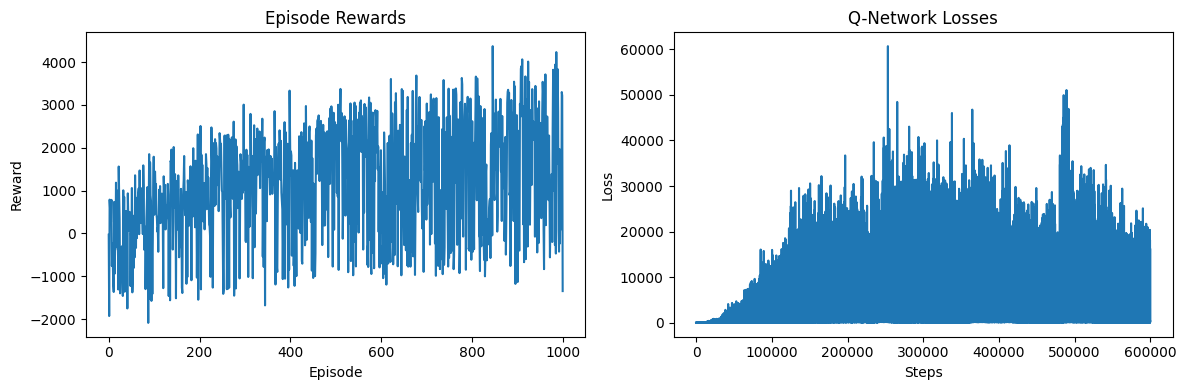

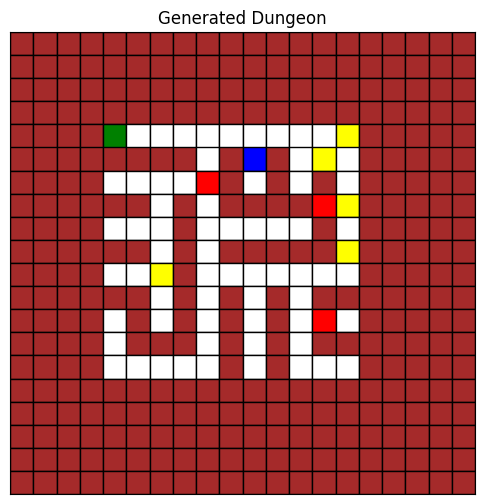

In [8]:
# Dropout
# Complexity mai number of elements
# Train and Visualize
if __name__ == "__main__":
    trained_agent, trained_envs = train_dungeon_generator(num_episodes=1000)
    generated_dungeon = generate_dungeon_with_model(trained_agent, 7)
    visualize_dungeon(generated_dungeon)

Difficulty: 8


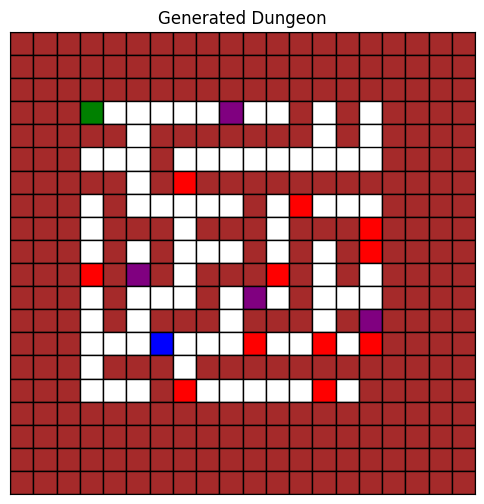

In [22]:
difficulty = 8
print(f"Difficulty: {difficulty}")
generated_dungeon = generate_dungeon_with_model(trained_agent, difficulty)
visualize_dungeon(generated_dungeon)